In [1]:
import sys
sys.path.append("../")

In [2]:
import os
import logging

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_tree
from xgboost import plot_importance
from pdpbox import info_plots
from pdpbox import pdp

from src.utils.logger import get_logger

import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
_ = get_logger(level=logging.ERROR)

## Config

In [4]:
base_dir = "../data/"
data_path = os.path.join(base_dir, "pima_indians_diabetes.csv")

## Load Dataset

In [5]:
data = pd.read_csv(data_path)

In [6]:
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [7]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
data.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

## Preprocess Dataset

In [9]:
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

In [11]:
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (614, 8)
y_train: (614,)
X_test: (154, 8)
y_test: (154,)


## Train Model

In [12]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [13]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [14]:
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

print(f"Train Accuracy (%): {acc_train*100:.2f}")
print(f"Test Accuracy (%): {acc_test*100:.2f}")

Train Accuracy (%): 100.00
Test Accuracy (%): 75.97


## Interpretation

### Tree Visualization

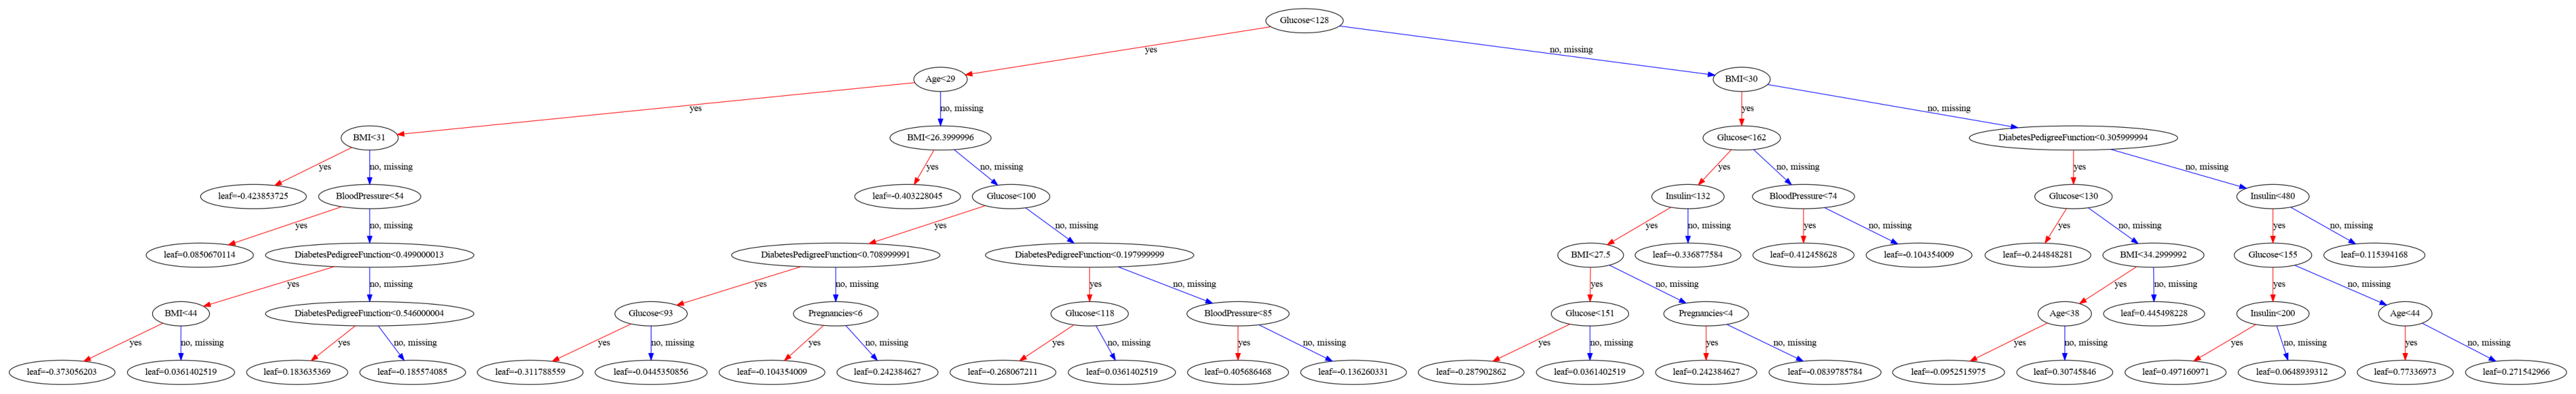

In [15]:
fig, ax = plt.subplots(figsize=(50, 25))
ax = plot_tree(model, ax=ax, num_trees=0)

In [16]:
value = [
    {
        'Pregnancies': 1,
        'Glucose': 161, 
        'BloodPressure': 72,
        'SkinThickness': 35,
        'Insulin': 0,
        'BMI': 28.1,
        'DiabetesPedigreeFunction': 0.527,
        'Age': 20,
    }
]

In [17]:
# Glucose >= 128, BMI < 30, Glucose < 162, Insulin < 132, BMI >= 27.5, Pregnancies < 4
#  logit = 0.242384627
# P(diabetes) = 0.64
# P(no diabetes) = 0.36

model.predict_proba(pd.DataFrame(value))

array([[0.35877454, 0.64122546]], dtype=float32)

In [18]:
# NOTE: this value may differ from model.predict_prob since XGBoost uses ensemble of trees to get a final output

1 / (1+np.exp(-0.242384627))

0.5603012191599062

### Feature Importance
1. estimate the original error $e_{orig} = L(y, \hat{f(X)})$
2. For each feature $j \in {1, ..., p}$ do:
    - Generate feature matrix $X_{perm}$ by permuting feature j in the data X. This breaks the association between feature j and true outcome y.
    - Estimate error $e_{perm}= L(y, \hat{f}(X_{perm})) based on the predictions of the perfumed data.$
    - Calculate permutation feature importance as quotient $FI_j=e_{perm}/e_{orig}$ or difference $FI_{j}=e_{perm}-e{orig}$
3. Sort features by descending FI

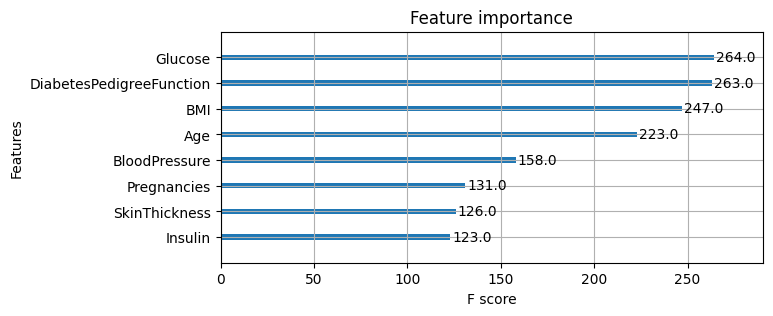

In [19]:
fig, ax = plt.subplots(figsize=(7, 3))
ax = plot_importance(model, ax=ax)

### Partial Dependence Plot (PDP)
Partial dependence function in regression model is defined as:
$$\hat{f_S}(x_S) = E_{X_C}\big[ \hat{f_S}(x_S, X_C)\big] = \int\hat{f_S}(x_S, X_C) d \mathbb{P}(X_C)$$
where
- $x_S$: feature to be visualized with PDP
- $X_C$: features used to train model excluding $x_S$

In practical, partial dependence function can be computed using train data with following Monte Carlo method:
$$\hat{f_S}(x_S) = \frac{1}{n}\sum_{i=1}^n \hat{f}(x_S, x^{(i)}_C)$$

In [20]:
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [21]:
feature_cols = data.columns[:-1].tolist()
target_col = data.columns[-1]

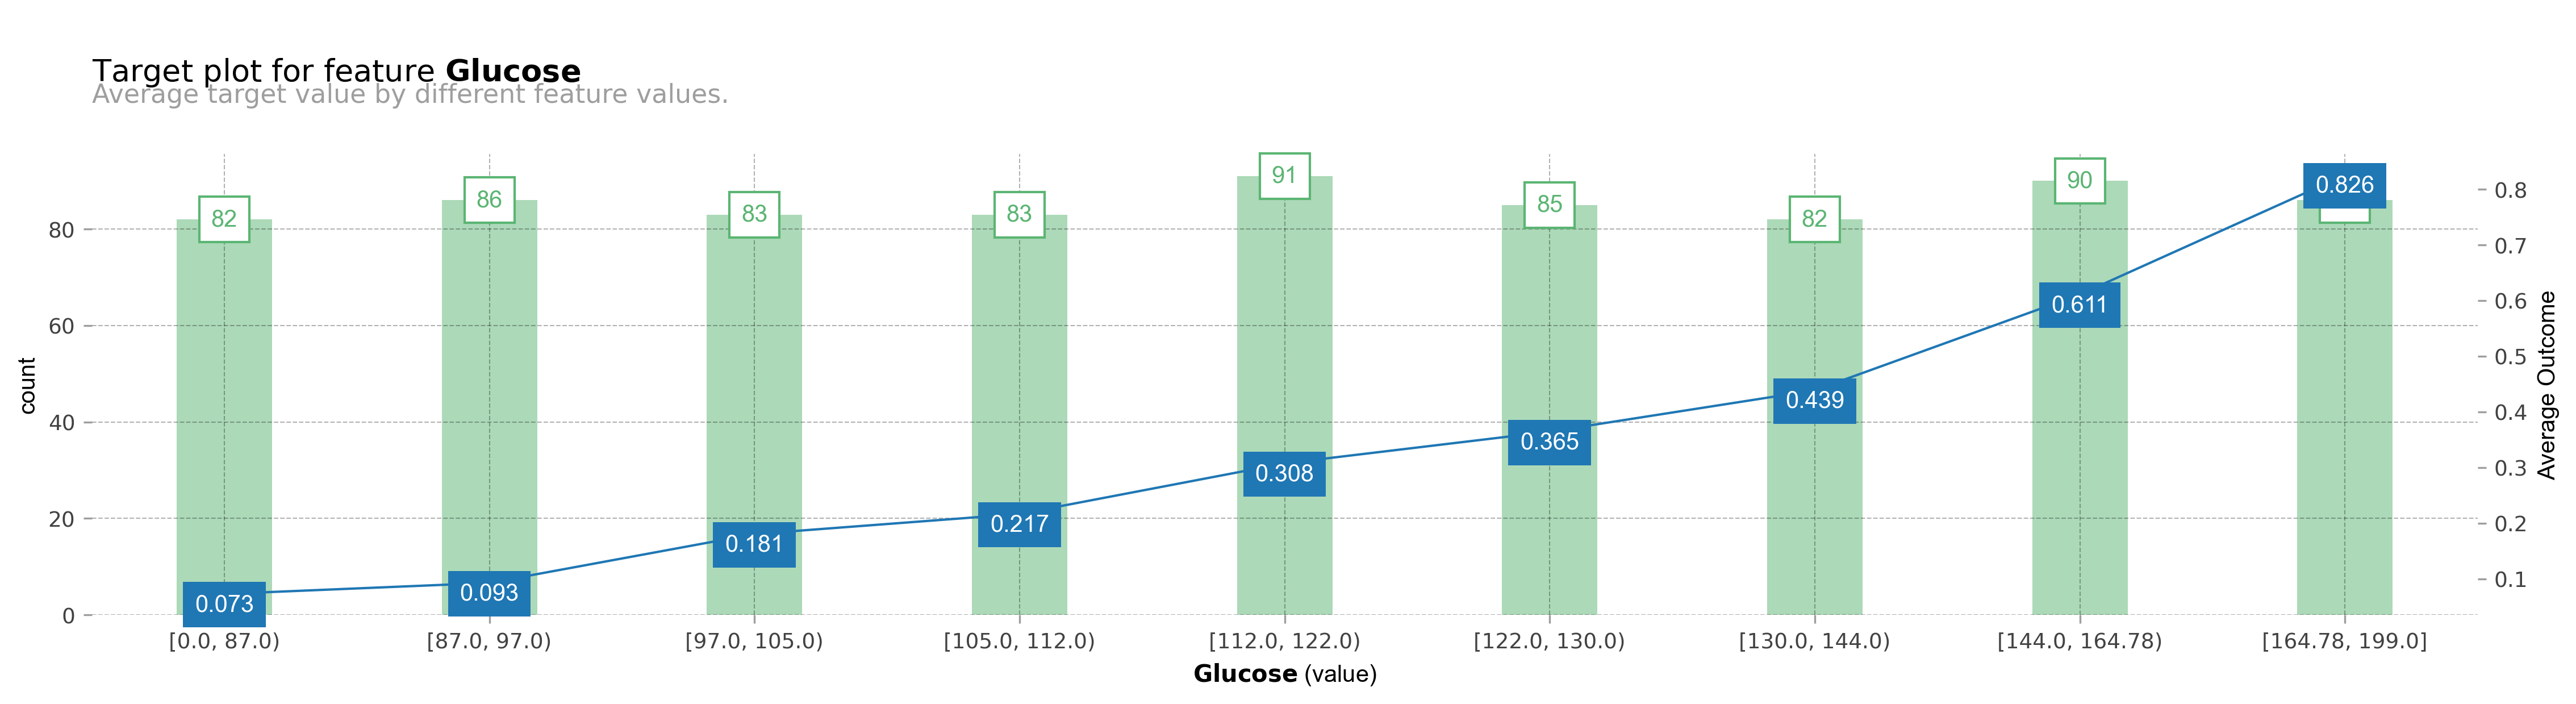

In [22]:
"""
TargetPlot provides insight how target vary over diffrent groups of given feature.

e.g. As Glucose level increase, the riskk of diabete also increase
"""

target_plot = info_plots.TargetPlot(
    df=data,
    feature="Glucose",
    feature_name="Glucose",
    target=target_col
)
fig, axes, summary_df = target_plot.plot(engine="matplotlib")
fig.subplots_adjust(right=1, top=0.5)

In [23]:
summary_df

x            value      percentile  count   Outcome
0  0      [0.0, 87.0)    [0.0, 11.11)     82  0.073171
1  1     [87.0, 97.0)  [11.11, 22.22)     86  0.093023
2  2    [97.0, 105.0)  [22.22, 33.33)     83  0.180723
3  3   [105.0, 112.0)  [33.33, 44.44)     83  0.216867
4  4   [112.0, 122.0)  [44.44, 55.56)     91  0.307692
5  5   [122.0, 130.0)  [55.56, 66.67)     85  0.364706
6  6   [130.0, 144.0)  [66.67, 77.78)     82  0.439024
7  7  [144.0, 164.78)  [77.78, 88.89)     90  0.611111
8  8  [164.78, 199.0]  [88.89, 100.0]     86  0.825581

obtain pred_func from the provided model.


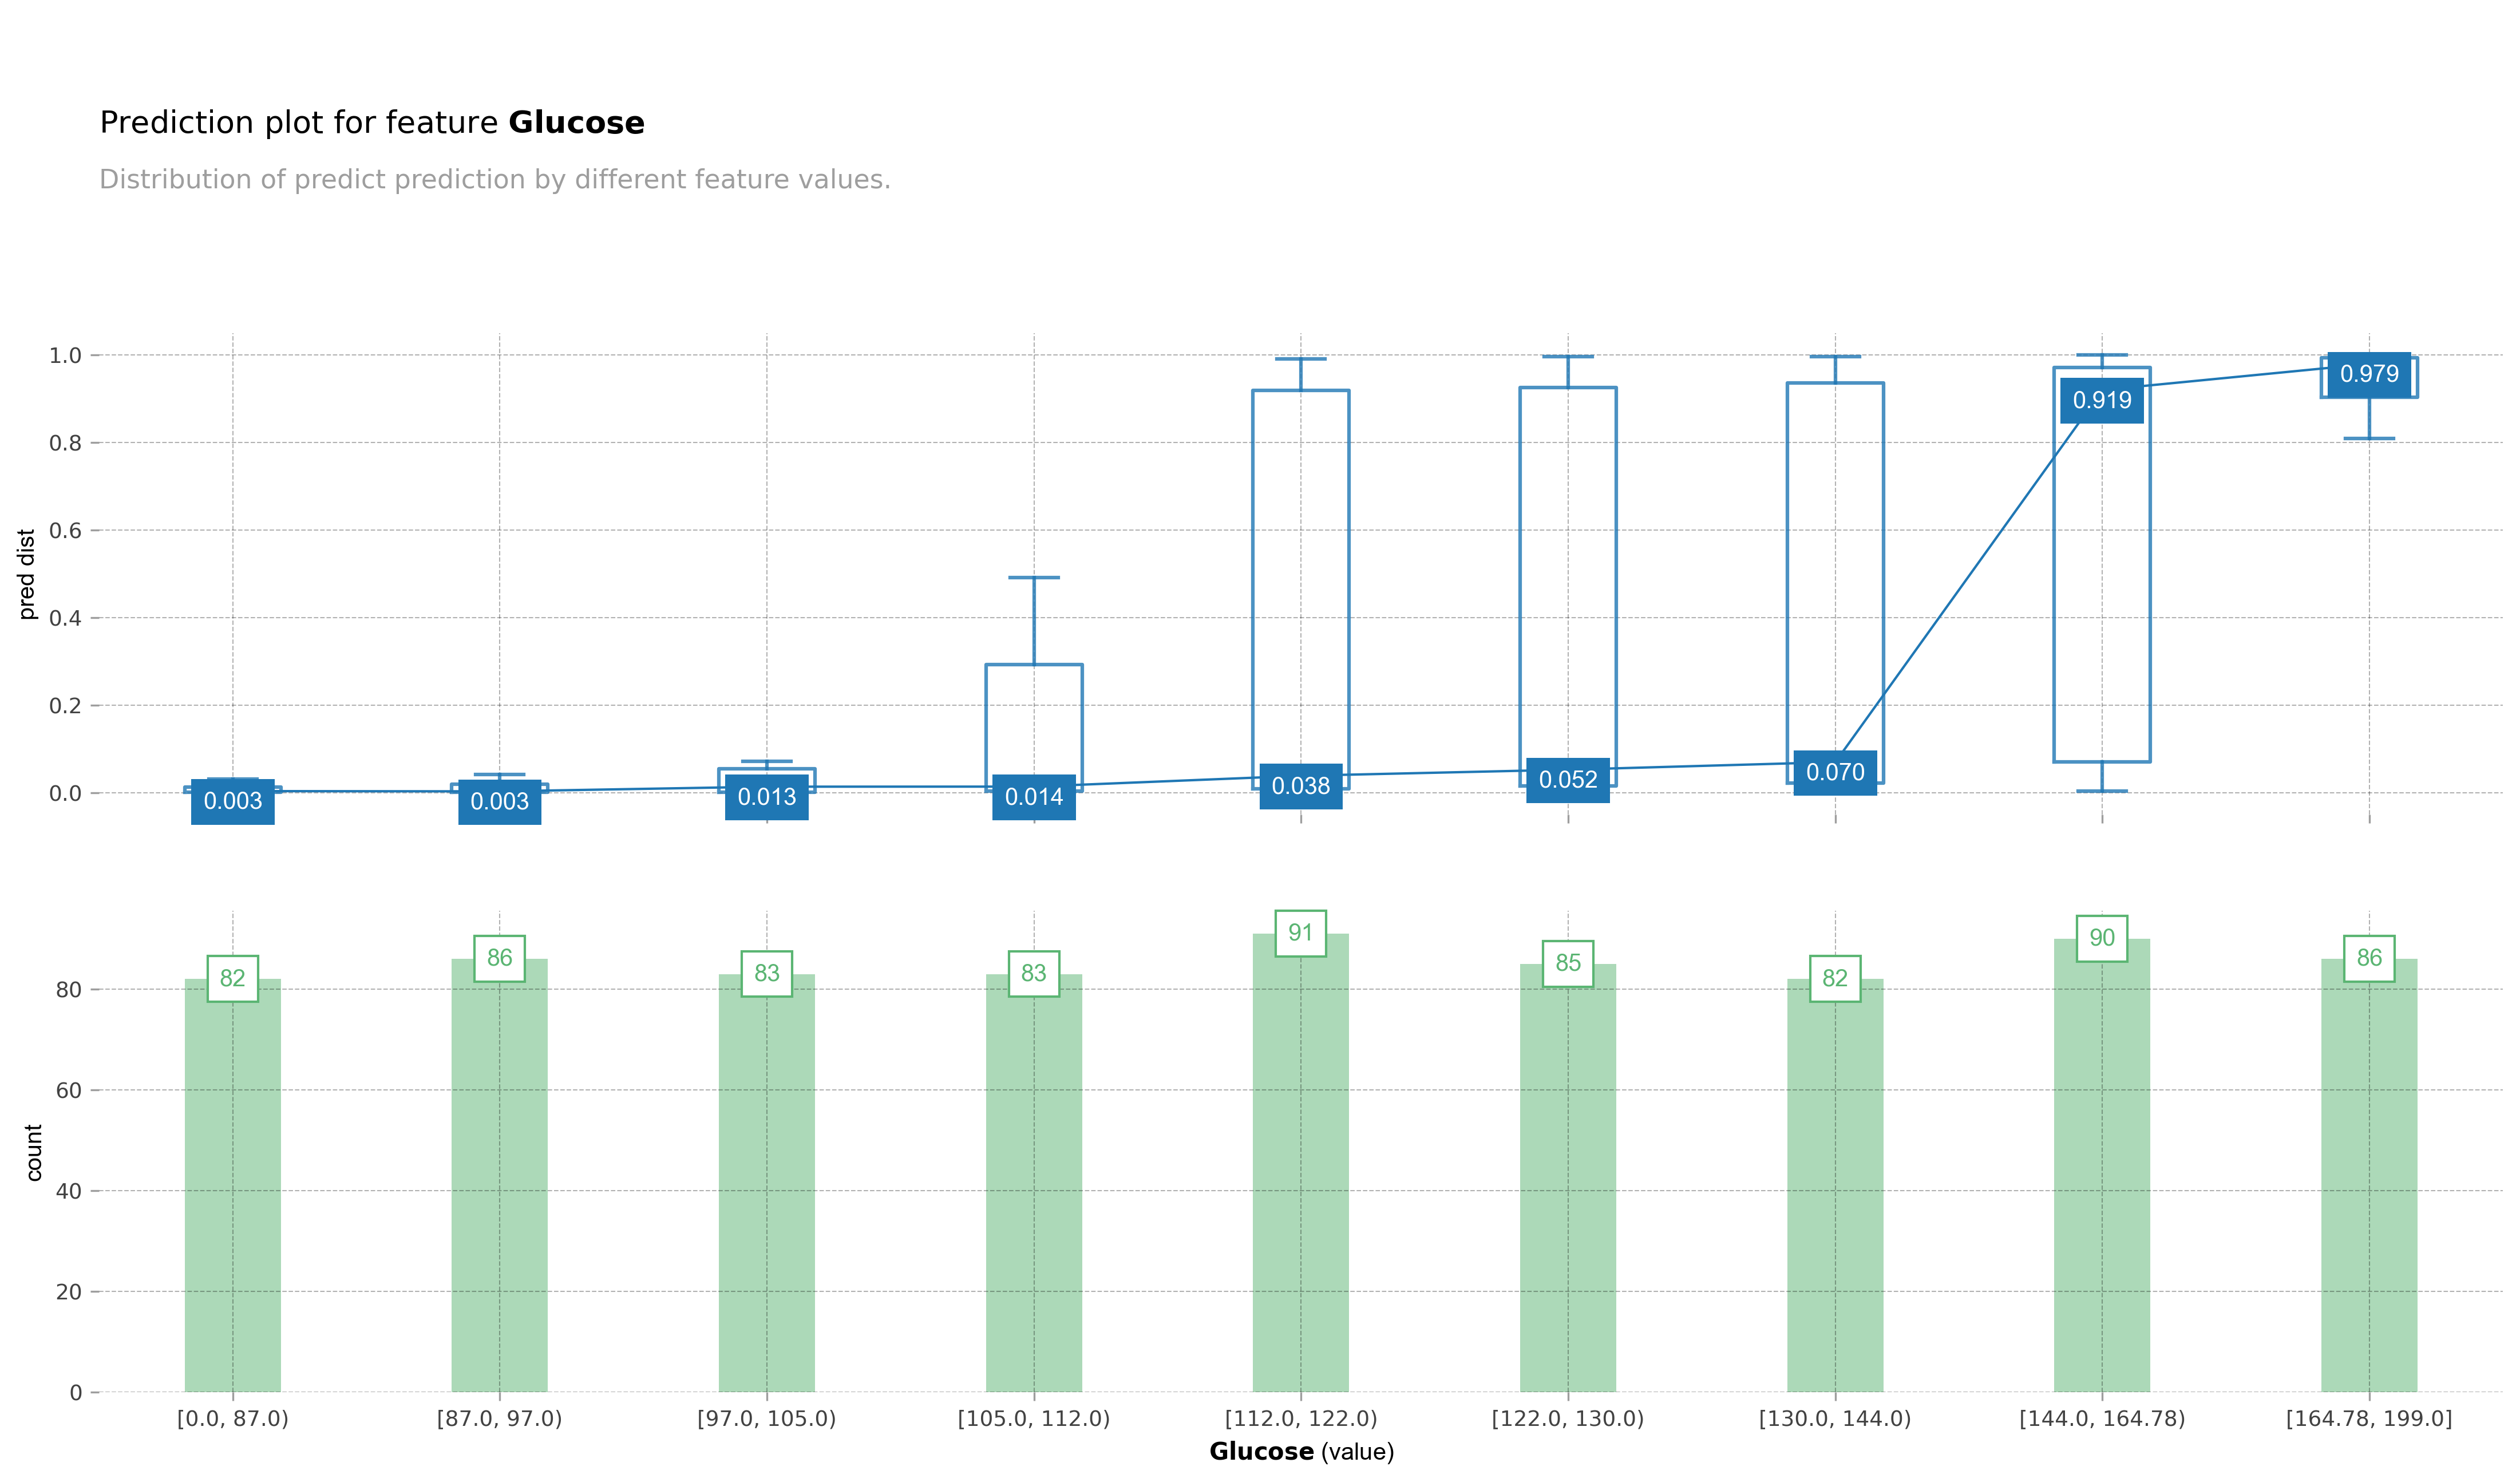

In [24]:
"""
PredictPlot provides the distribution of prediction values.
- pred_dist: outcome probability for diffrent groups of given feature
- count: sample size for diffrent groups of given feature
"""

predict_plot = info_plots.PredictPlot(
    df=data,
    feature="Glucose",
    feature_name="Glucose",
    model=model,
    model_features=feature_cols,
)
fig, axes, summary_df = predict_plot.plot(engine="matplotlib")
fig.subplots_adjust(right=1, top=1)

In [25]:
summary_df

x            value      percentile  count   pred_q1   pred_q2   pred_q3
0  0      [0.0, 87.0)    [0.0, 11.11)     82  0.001042  0.003381  0.012946
1  1     [87.0, 97.0)  [11.11, 22.22)     86  0.000465  0.002753  0.018599
2  2    [97.0, 105.0)  [22.22, 33.33)     83  0.001083  0.013440  0.054853
3  3   [105.0, 112.0)  [33.33, 44.44)     83  0.003103  0.013603  0.292751
4  4   [112.0, 122.0)  [44.44, 55.56)     91  0.008910  0.038372  0.918236
5  5   [122.0, 130.0)  [55.56, 66.67)     85  0.015114  0.052262  0.924858
6  6   [130.0, 144.0)  [66.67, 77.78)     82  0.021662  0.069604  0.934730
7  7  [144.0, 164.78)  [77.78, 88.89)     90  0.069605  0.919272  0.970973
8  8  [164.78, 199.0]  [88.89, 100.0]     86  0.902154  0.978788  0.993032

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

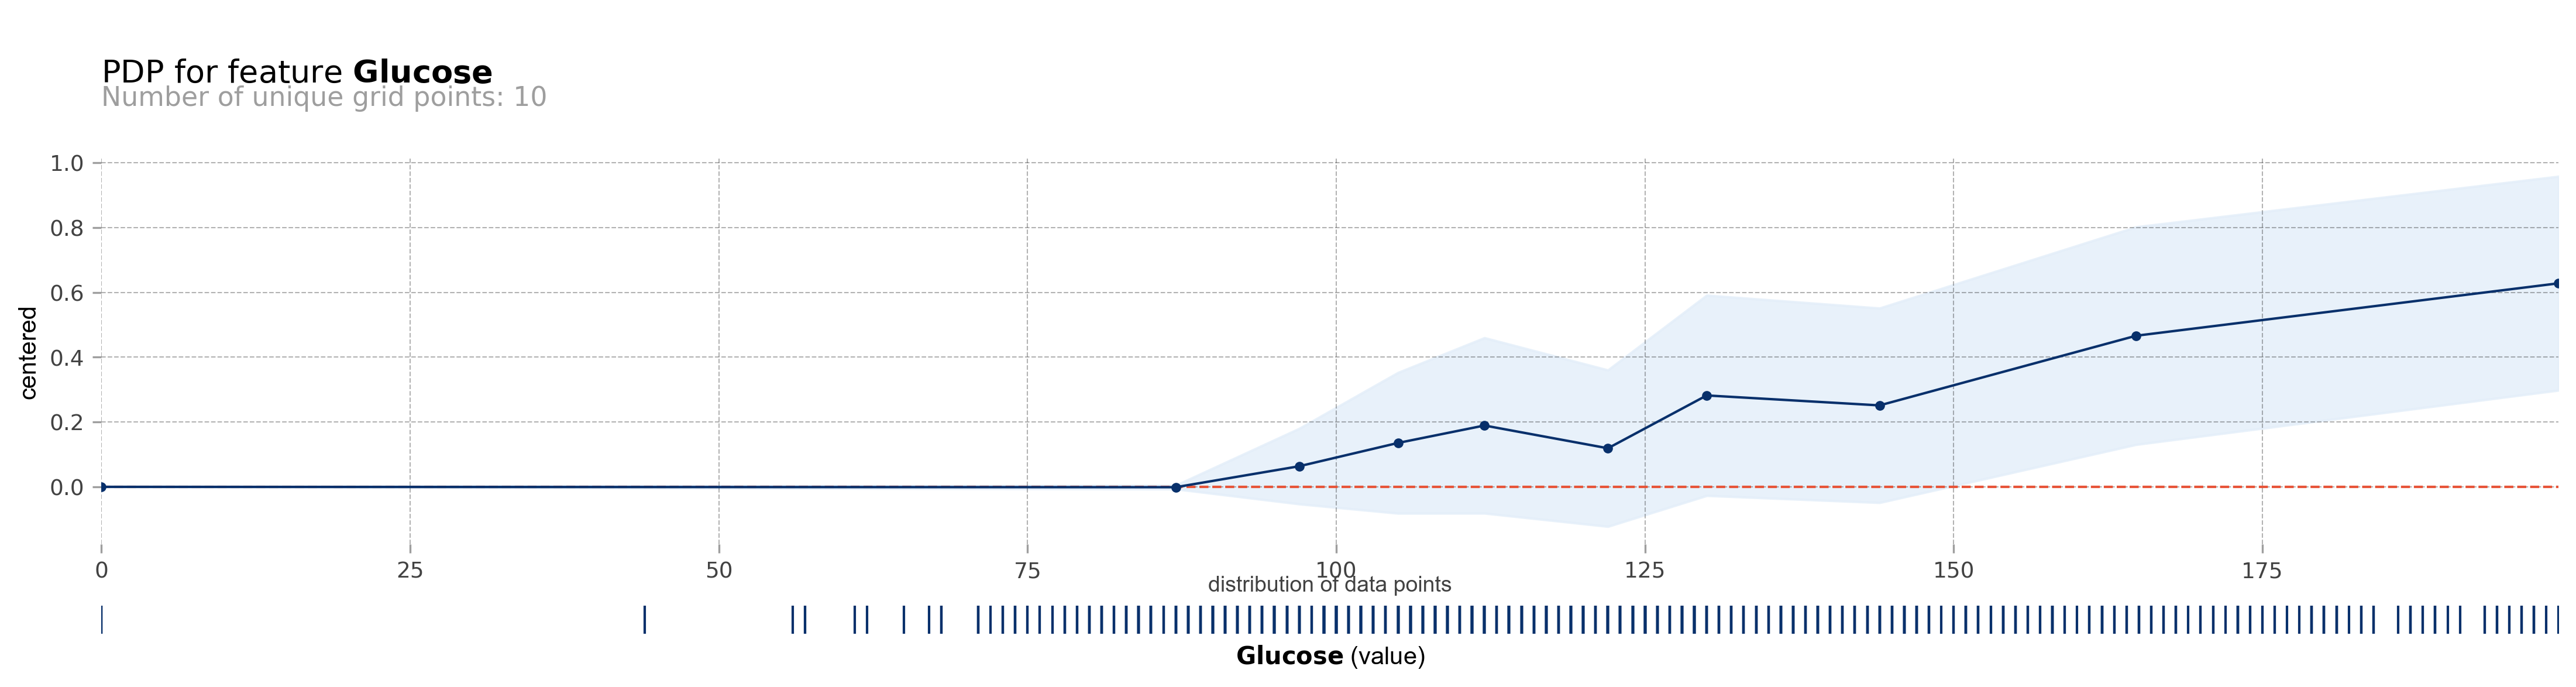

In [26]:
"""
PDPIsolate provides PDP on a single feature
- plot_lines: ICE lines will be plotted if True
- plot_pts_dist: distribution of points will be plotted if True
"""

isolate_plot = pdp.PDPIsolate(
    model=model,
    df=data,
    model_features=feature_cols,
    feature="Glucose",
    feature_name="Glucose",
)
fig, axes = isolate_plot.plot(
    plot_lines=False,
    plot_pts_dist=True,
    engine="matplotlib",
)
fig.subplots_adjust(right=1, top=0.5)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

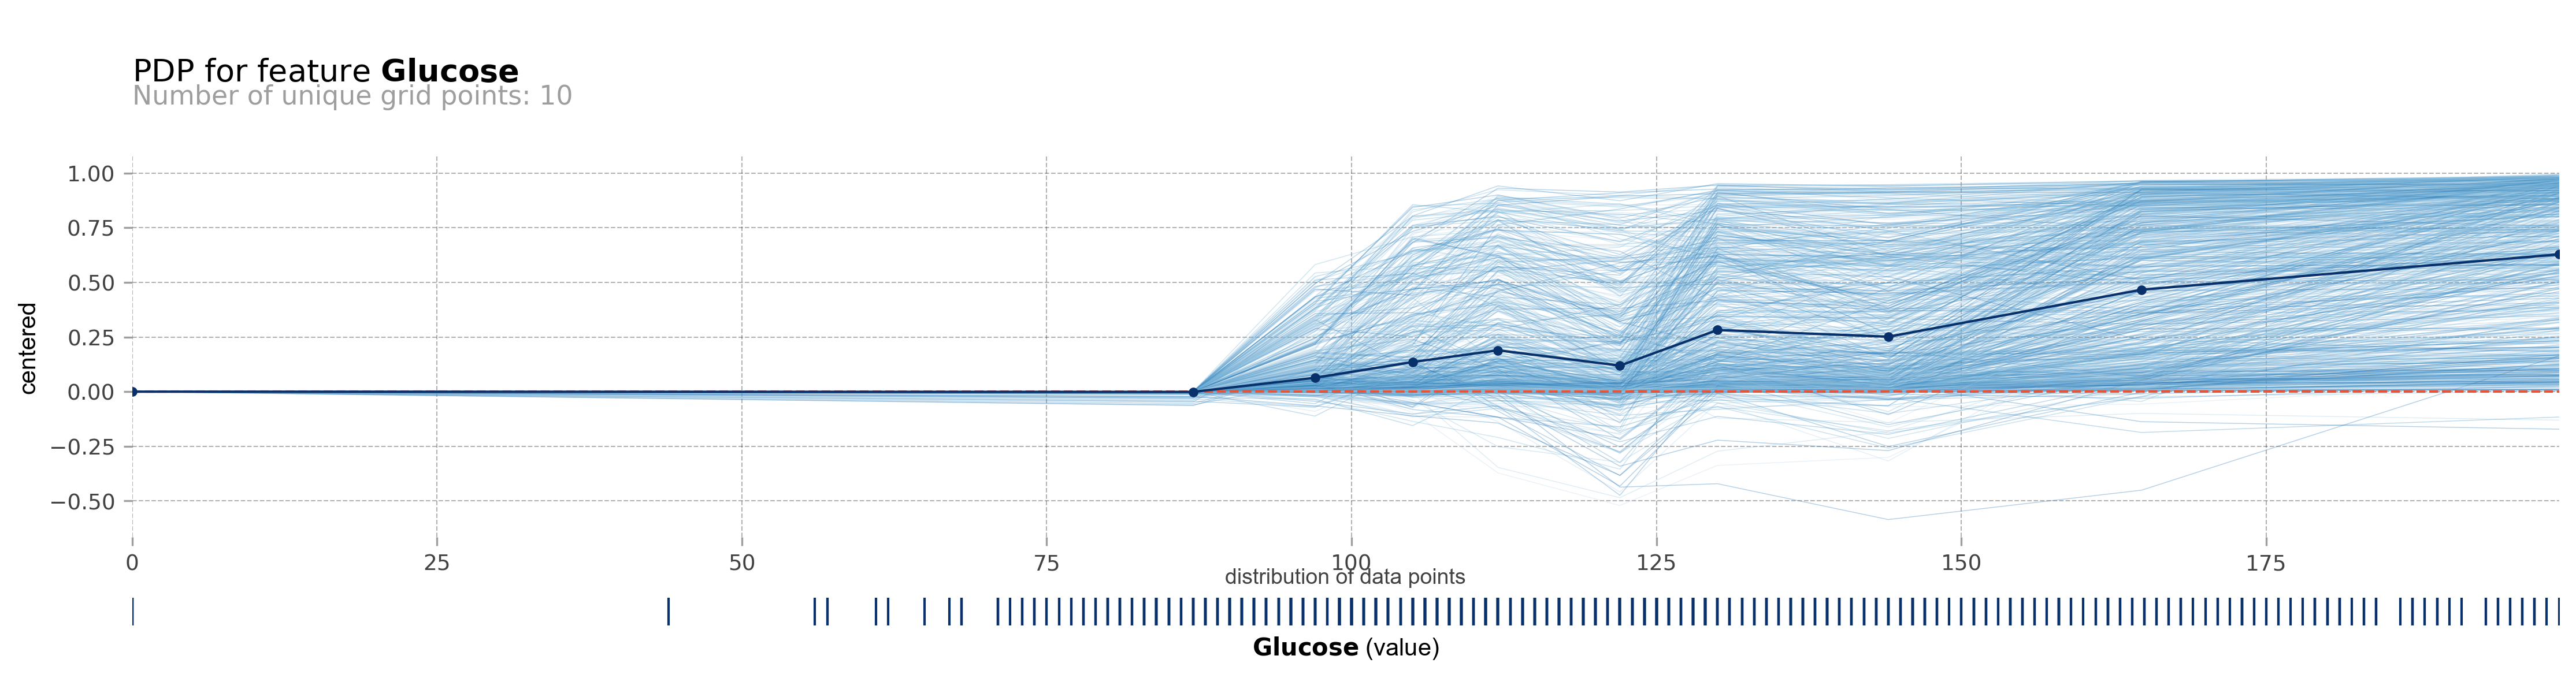

In [27]:
isolate_plot = pdp.PDPIsolate(
    model=model,
    df=data,
    model_features=feature_cols,
    feature="Glucose",
    feature_name="Glucose",
)
fig, axes = isolate_plot.plot(
    plot_lines=True,
    plot_pts_dist=True,
    engine="matplotlib",
)
fig.subplots_adjust(right=1, top=0.5)

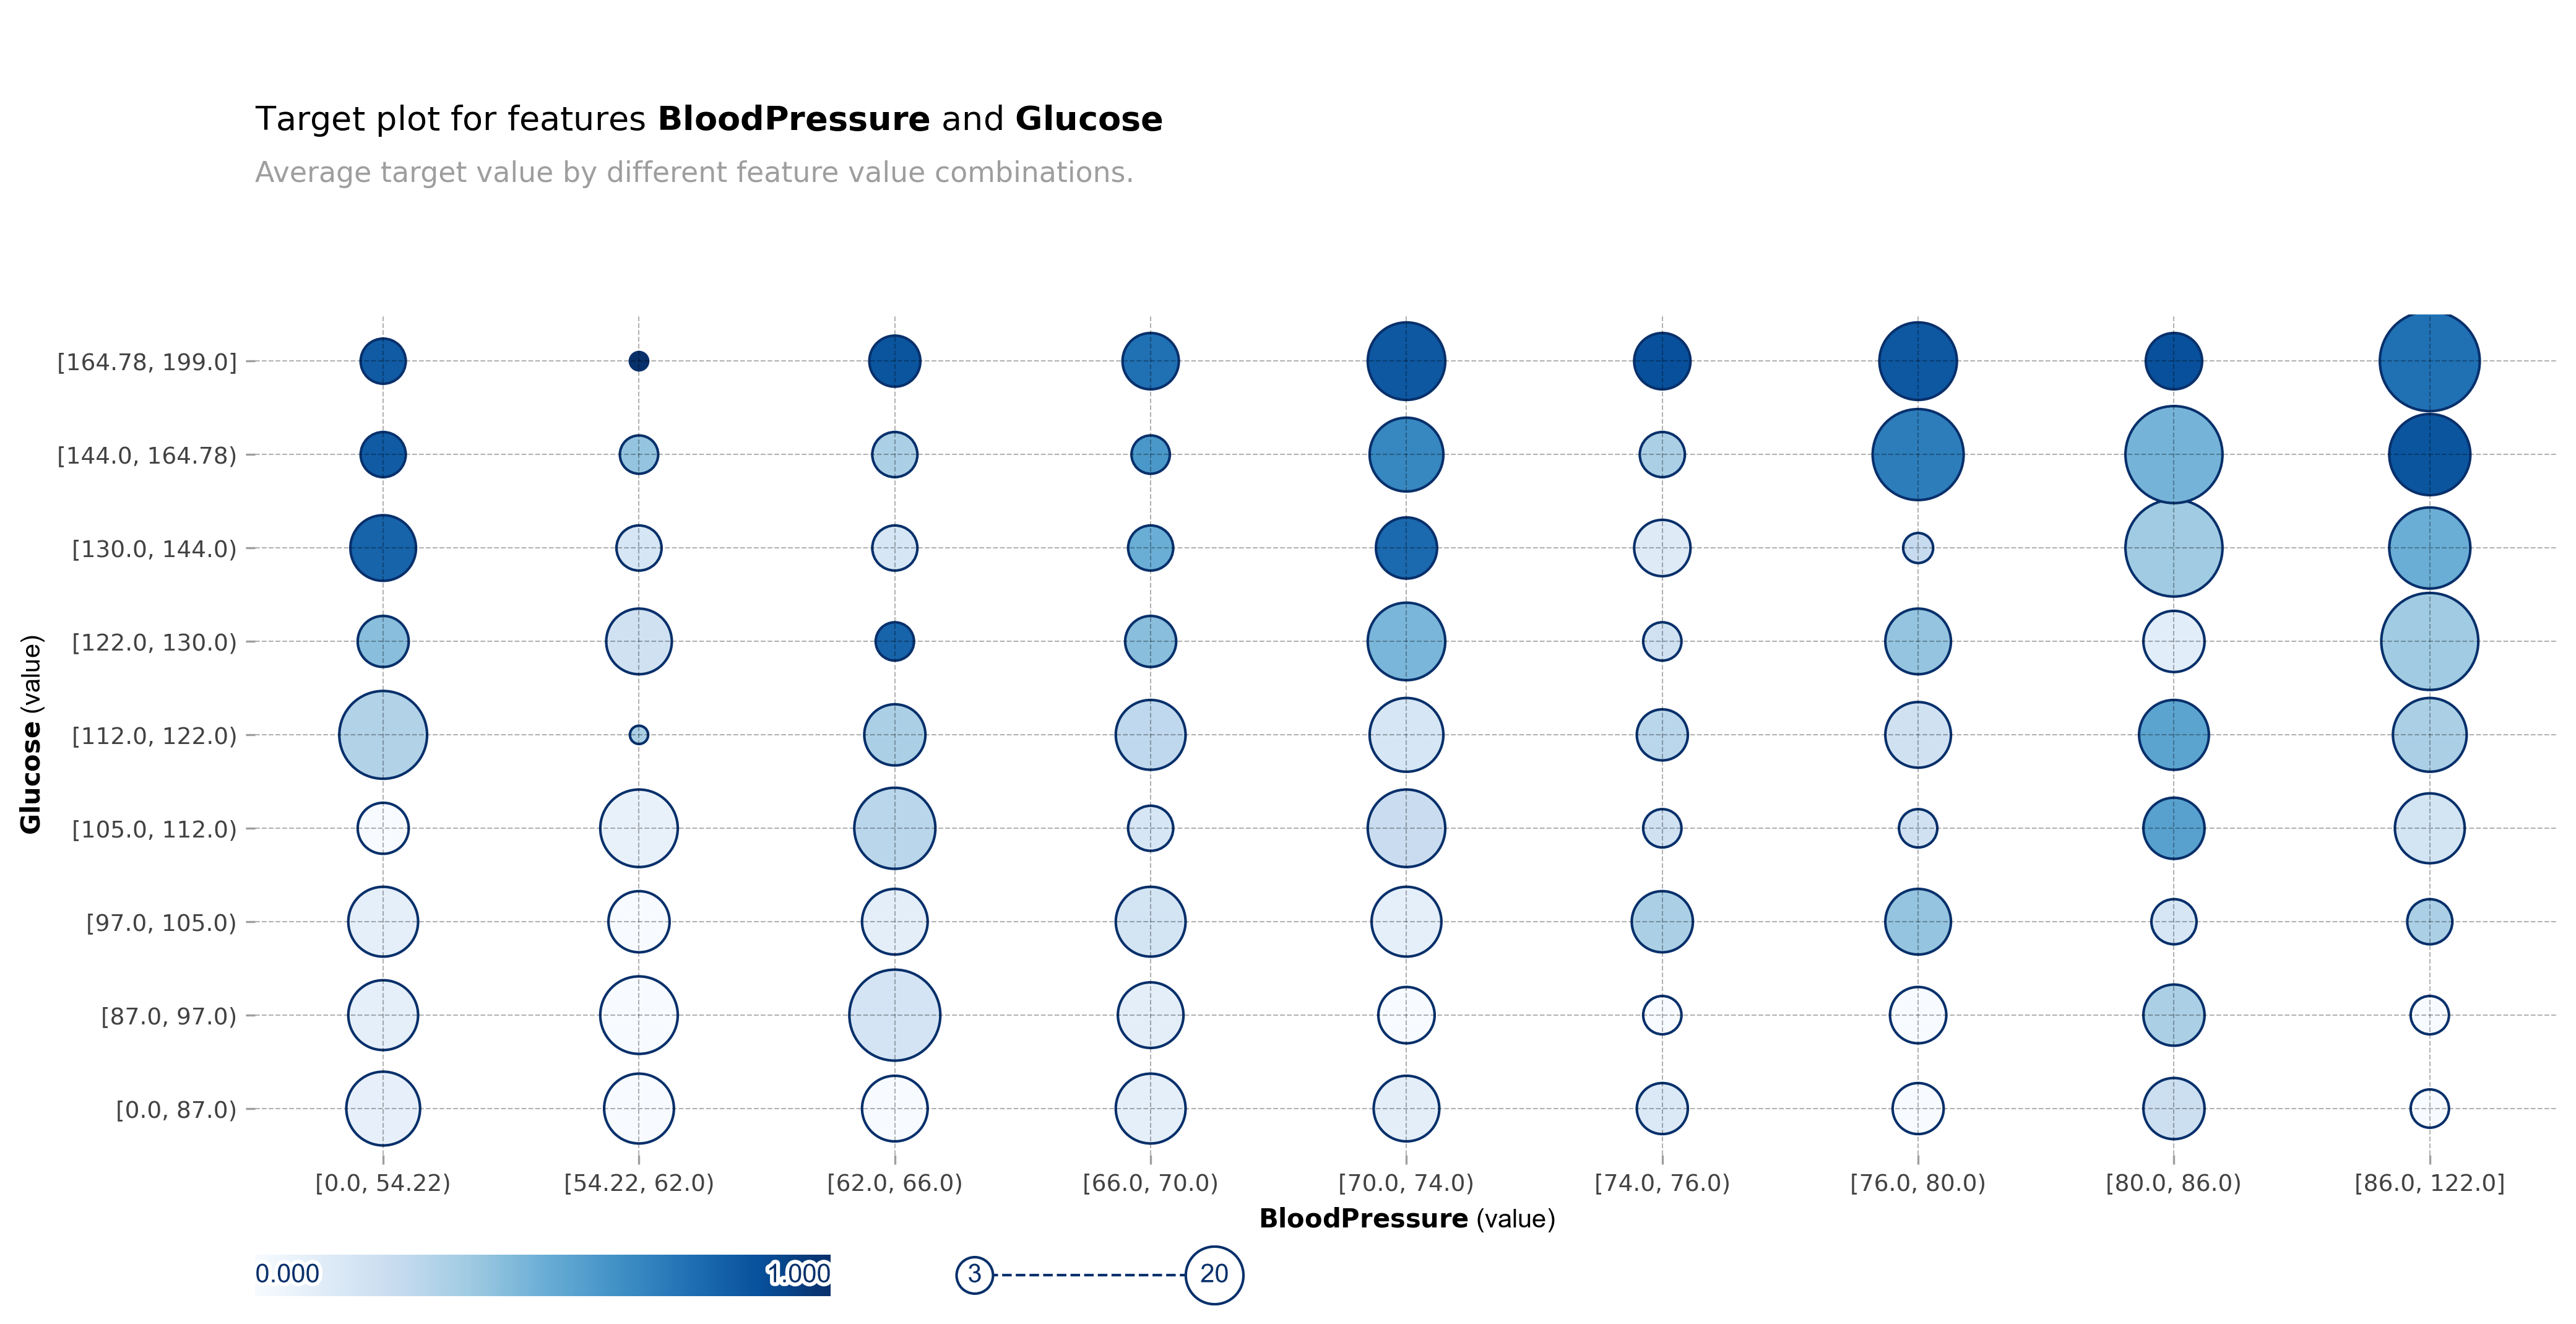

In [28]:
"""
InteractTargetPlot provides TargetPlot for interaction between two features.
- the size of circle implies the density of data in given interval
- the color of circle implies the probability of outcome in given interval
"""

interact_target_plot = info_plots.InteractTargetPlot(
    df=data,
    features=["BloodPressure", "Glucose"],
    feature_names=["BloodPressure", "Glucose"],
    target=target_col,
)
fig, axes, summary_df = interact_target_plot.plot(engine="matplotlib")

In [29]:
summary_df

x1  x2        value_1          value_2    percentile_1    percentile_2  \
0    0   0   [0.0, 54.22)      [0.0, 87.0)    [0.0, 11.11)    [0.0, 11.11)   
1    0   1   [0.0, 54.22)     [87.0, 97.0)    [0.0, 11.11)  [11.11, 22.22)   
2    0   2   [0.0, 54.22)    [97.0, 105.0)    [0.0, 11.11)  [22.22, 33.33)   
3    0   3   [0.0, 54.22)   [105.0, 112.0)    [0.0, 11.11)  [33.33, 44.44)   
4    0   4   [0.0, 54.22)   [112.0, 122.0)    [0.0, 11.11)  [44.44, 55.56)   
..  ..  ..            ...              ...             ...             ...   
76   8   4  [86.0, 122.0]   [112.0, 122.0)  [88.89, 100.0]  [44.44, 55.56)   
77   8   5  [86.0, 122.0]   [122.0, 130.0)  [88.89, 100.0]  [55.56, 66.67)   
78   8   6  [86.0, 122.0]   [130.0, 144.0)  [88.89, 100.0]  [66.67, 77.78)   
79   8   7  [86.0, 122.0]  [144.0, 164.78)  [88.89, 100.0]  [77.78, 88.89)   
80   8   8  [86.0, 122.0]  [164.78, 199.0]  [88.89, 100.0]  [88.89, 100.0]   

    count   Outcome  
0      12  0.083333  
1      11  0.090909  
2      11  0.090909  
3       7  0.000000  
4      16  0.312500  
..    ...       ...  
76     12  0.333333  
77     19  0.368421  
78     14  0.500000  
79     14  0.857143  
80     20  0.750000  

[81 rows x 8 columns]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/100 [00:00<?, ?it/s]

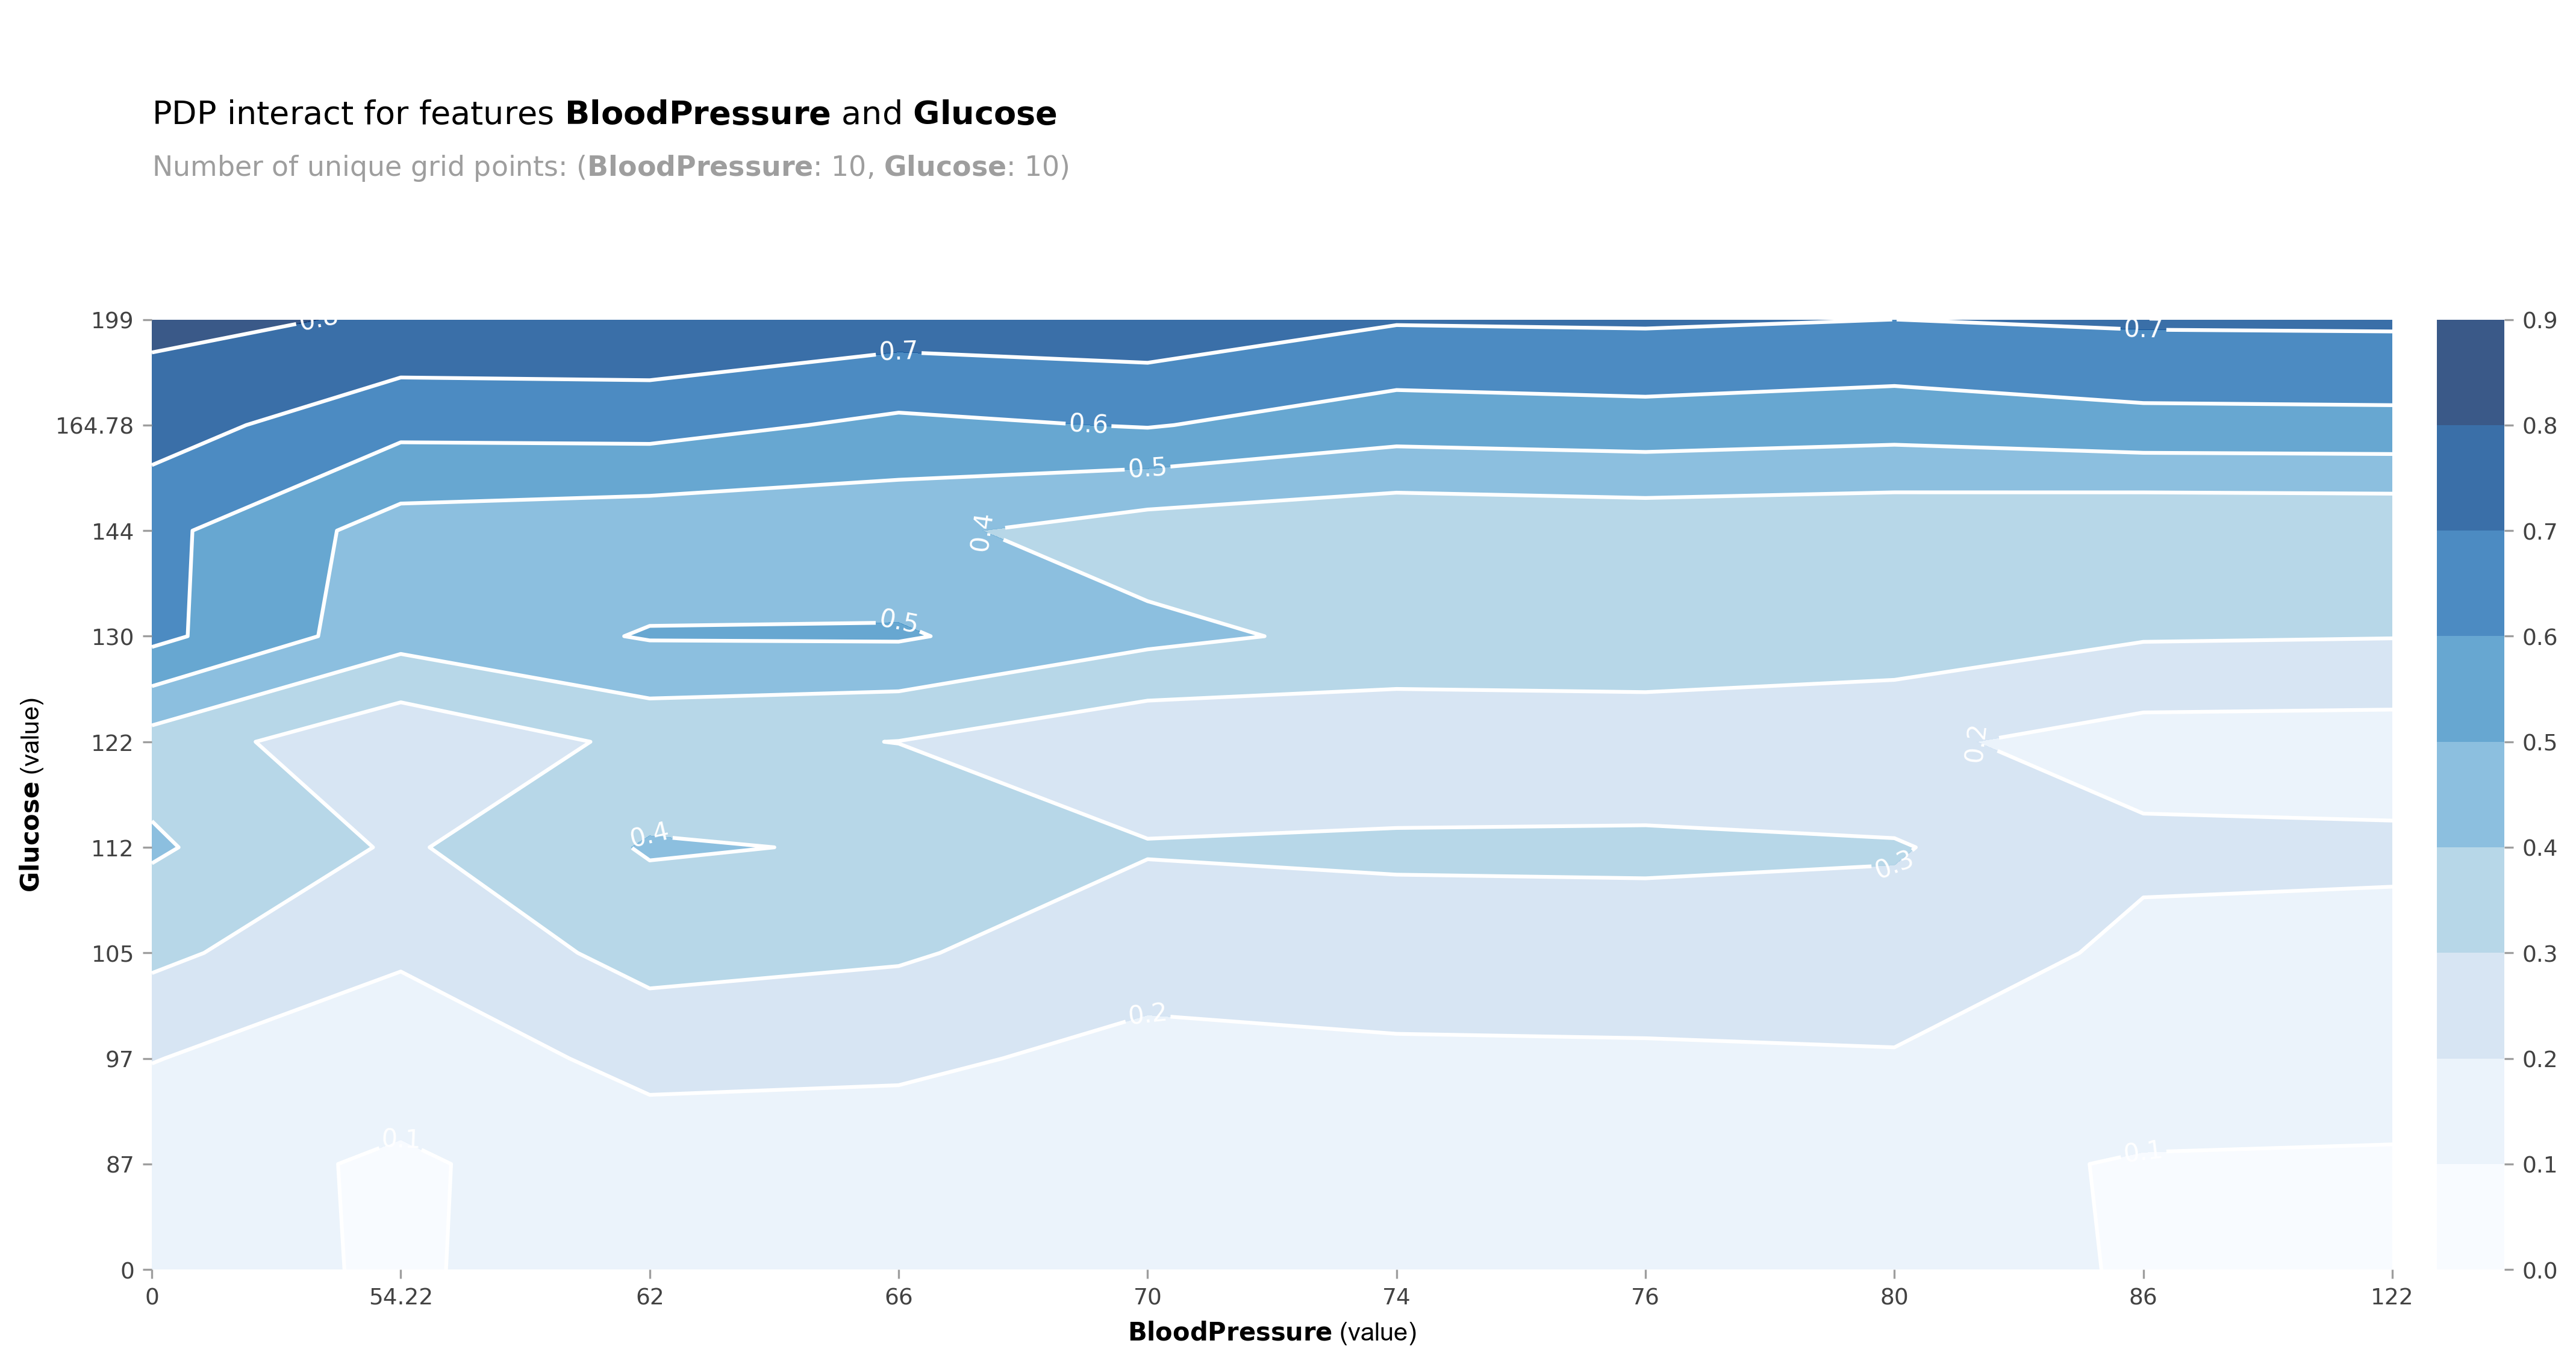

In [30]:
"""
PDPInteract provides PDP analysis for interaction between two features.
"""

interact_plot = pdp.PDPInteract(
    model=model,
    df=data,
    model_features=feature_cols,
    features=["BloodPressure", "Glucose"],
    feature_names=["BloodPressure", "Glucose"],
)
fig, axes = interact_plot.plot(plot_type="contour", engine="matplotlib")

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/100 [00:00<?, ?it/s]

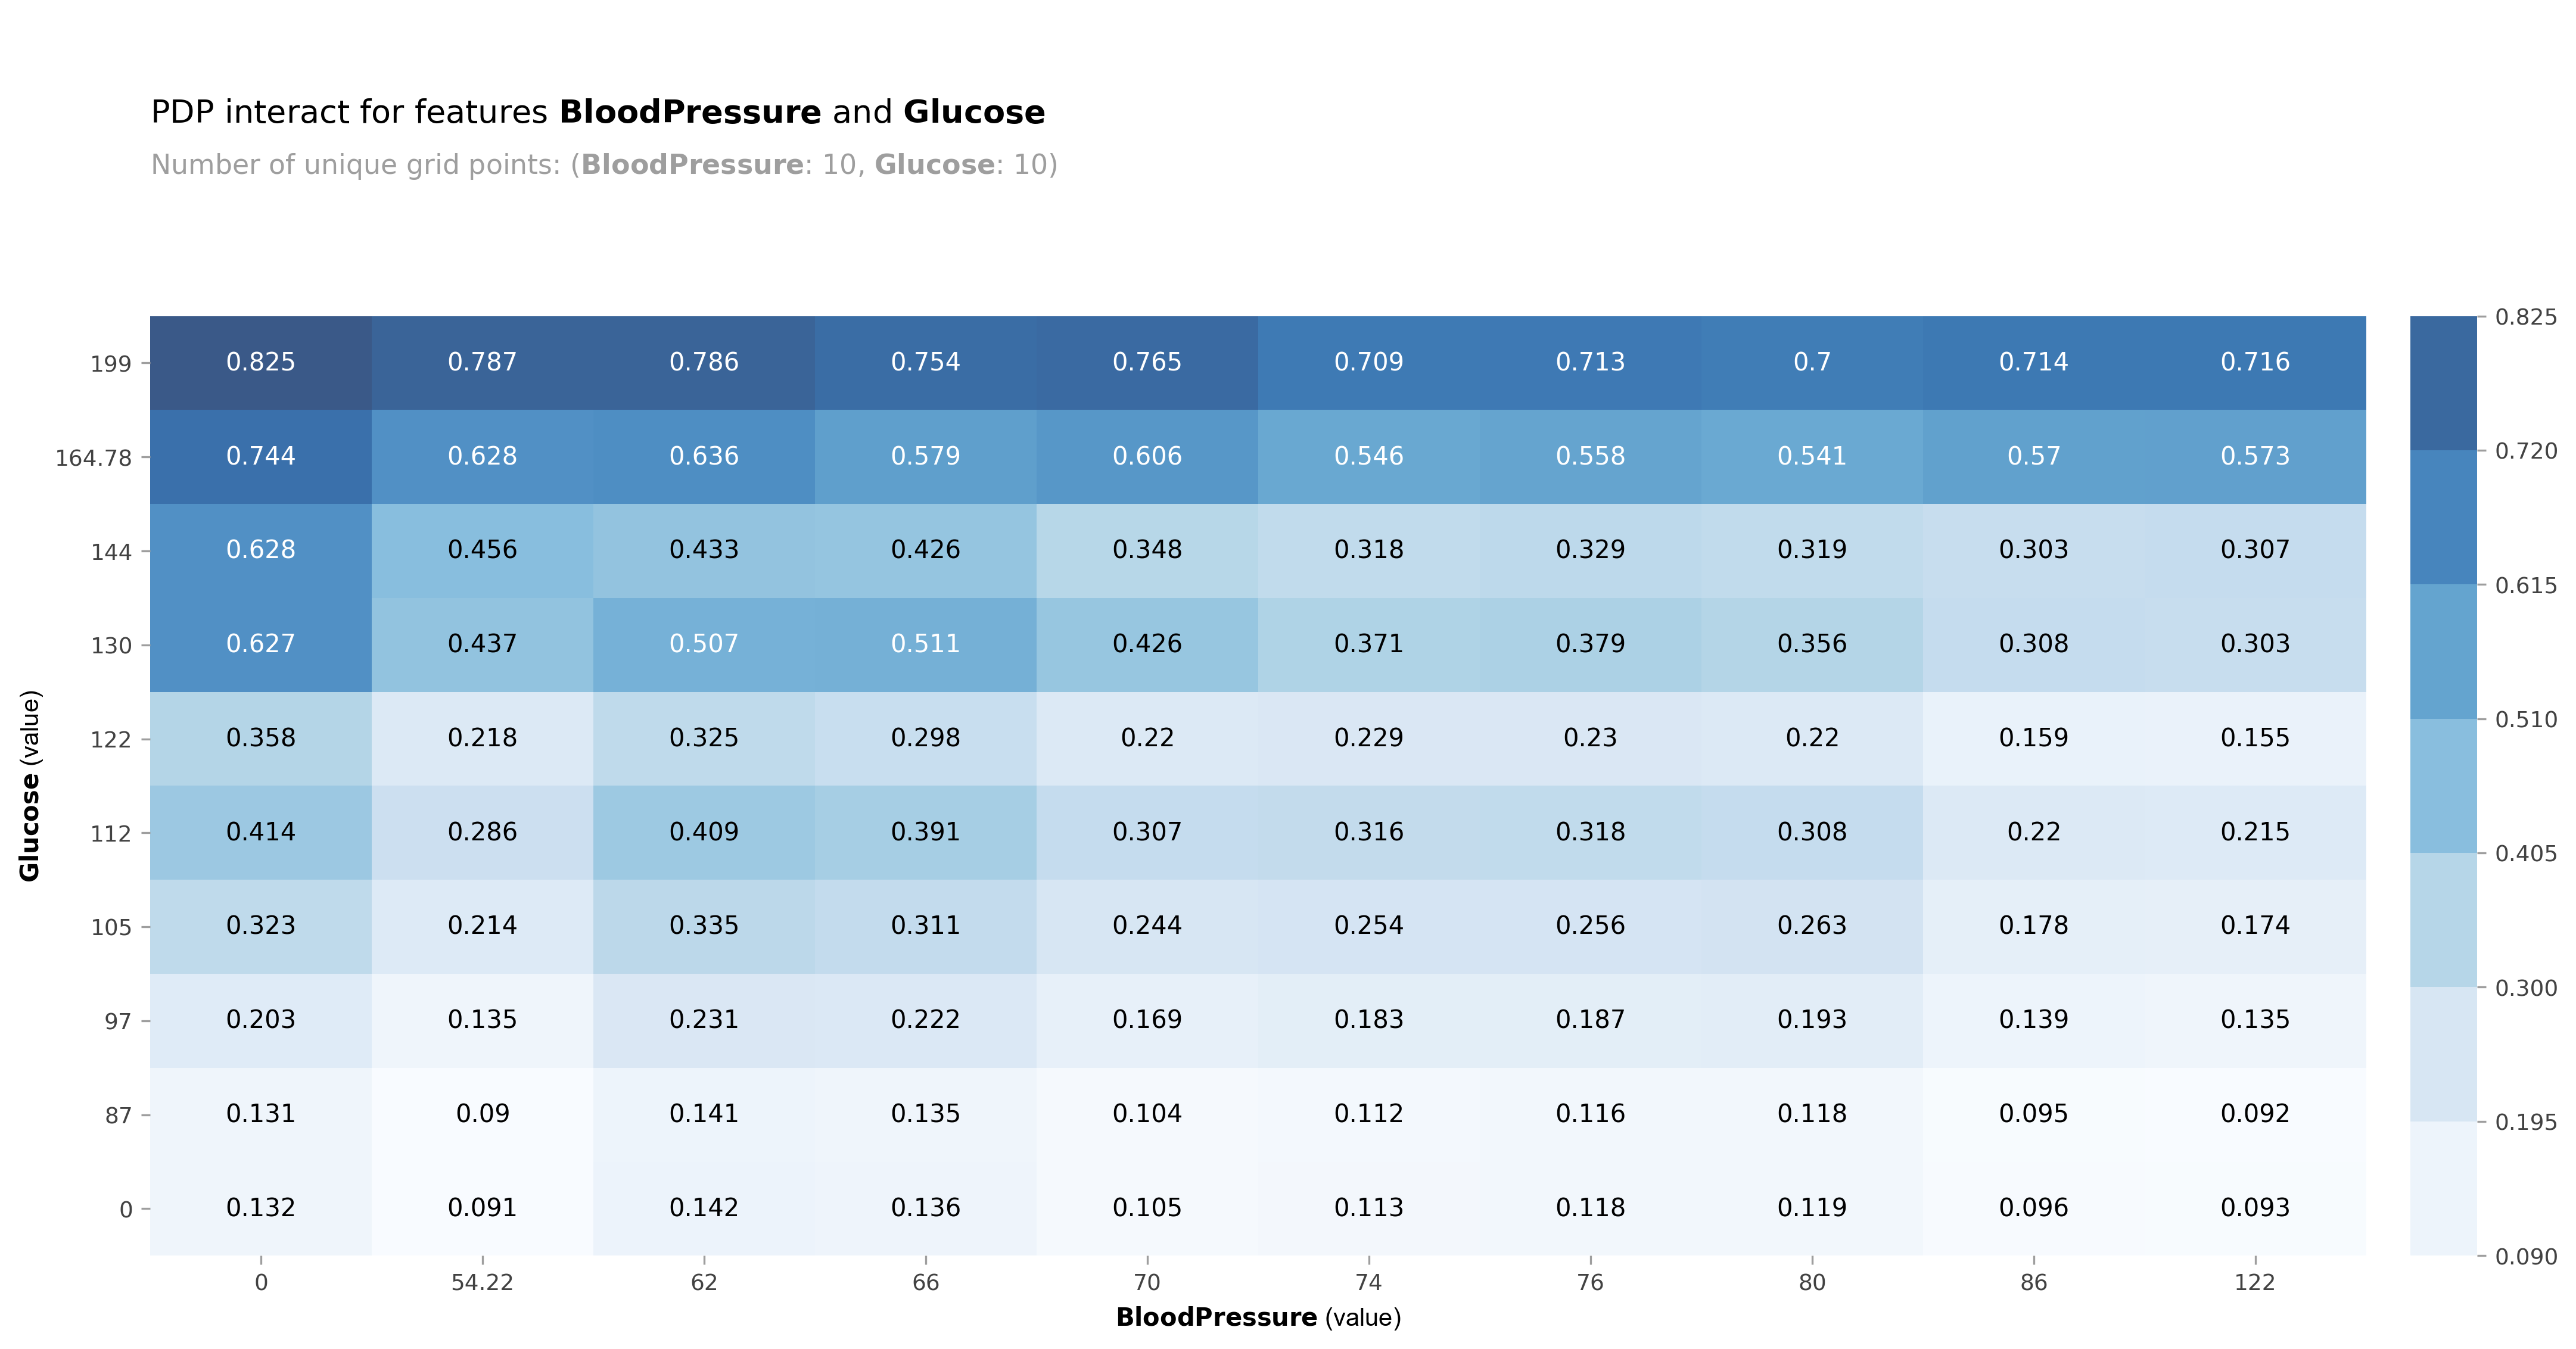

In [31]:
"""
PDPInteract provides PDP analysis for interaction between two features.
"""

interact_plot = pdp.PDPInteract(
    model=model,
    df=data,
    model_features=feature_cols,
    features=["BloodPressure", "Glucose"],
    feature_names=["BloodPressure", "Glucose"],
)
fig, axes = interact_plot.plot(plot_type="grid", engine="matplotlib")